### 目的：

1. 找出泰坦尼克事故中，可能和生还状态相关的特征
2. 根据特征建立模型，预测乘客是否生还


数据集来自：https://www.kaggle.com/c/titanic


In [197]:
import numpy as np
import pandas as pd
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
# 先了解训练数据
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


##### 变量解释：
- Survival: 是否生还  0 = No, 1 = Yes，是要预测的目标变量
- Pclass: 座位等级，作为社会经济地位的代替指标	1 = 上层阶级, 2 = 中层阶级, 3 = 下层阶级
- Sex: 性别
- Age: 年龄（year为单位，如果是估计年龄，形式为xx.5）
- Sibsp: 船上的家庭成员数量，包括siblings（兄弟姊妹）/ spouses（配偶）
- Parch: 船上的父母或孩子的数量；有些孩子由看护照看，所以parch=0
- Ticket: 票号
- Fare: 旅客票价
- Cabin: 座舱号	
- Embarked: 出发港 C = Cherbourg, Q = Queenstown, S = Southampton


##### 初步判断：
1. Age年龄、Cabin座舱号、出发港Embarked有缺失值
2. 根据日常经验，可以有如下预期：
    - 性别上，女性比男性更有可能生还，男性可能倾向于保护女性
    - 社会经济地位上，上层阶级更有可能生还
    - 年龄上，青壮年更有生命力，更有可能生还，当然也有可能青壮年会为了保护年幼或年长者，生还率较低
    - 家庭成员数也有影响，具体不太好猜测
    - 票价越高者，可能生还率更高，与社会经济地位同理
    - 出发港可能有影响，由于不太了解地理文化特征，不太好猜测


In [38]:
df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


#### 查看性别与生还状态的关系

In [39]:
df.groupby(['Survived'])['PassengerId'].count()

Survived
0    549
1    342
Name: PassengerId, dtype: int64

In [40]:
pd.pivot_table(df,index=['Sex'],columns=['Survived'], values = ['PassengerId'],\
               aggfunc=[np.count_nonzero])

count_nonzero     
           PassengerId     
Survived             0    1
Sex                        
female              81  233
male               468  109

In [41]:
# 性别与生还状态的卡方独立性检验
core_sex = np.array([[81, 233],
                   [468, 109]])

chi_2, p, d_f, hypo = st.chi2_contingency(core_sex)
chi_2, p, hypo

(260.71702016732104,
 1.1973570627755645e-58,
 array([[ 193.47474747,  120.52525253],
        [ 355.52525253,  221.47474747]]))

- 卡方值260，p值明显小于0.001，偏离独立假设下的预期值，可以说性别与生还状态之间显著不独立
- 女性的生还比率显著高于男性

#### 查看社会阶级地位与生还状态的关系

In [42]:
pd.pivot_table(df,index=['Pclass'],columns=['Survived'], values = ['PassengerId'],\
               aggfunc=[np.count_nonzero])

count_nonzero     
           PassengerId     
Survived             0    1
Pclass                     
1                   80  136
2                   97   87
3                  372  119

In [43]:
# 对社会阶级与幸存状态进行卡方独立性检验
core_pclass = np.array([[80, 136],
                        [97, 87],
                        [372, 119]])

chi_2, p, d_f, hypo = st.chi2_contingency(core_pclass)
chi_2, p, hypo

(102.88898875696056,
 4.5492517112987927e-23,
 array([[ 133.09090909,   82.90909091],
        [ 113.37373737,   70.62626263],
        [ 302.53535354,  188.46464646]]))

- p值很小，可以说社会阶级与幸存状态不是独立的
- 上层阶级的生还率高于预期很多，中层阶级生还率略高于预期，下层阶级生还率低于预期

#### 查看年龄和生还状态的关系

In [44]:
# 探索年龄和生还状态的关系, 注意年龄本身有缺失值估计的值
# 查看年龄分布
df_new = df[df['Age'].notnull()]

age_sur = df_new[df_new['Survived']==1]
age_notsur = df_new[df_new['Survived']==0]


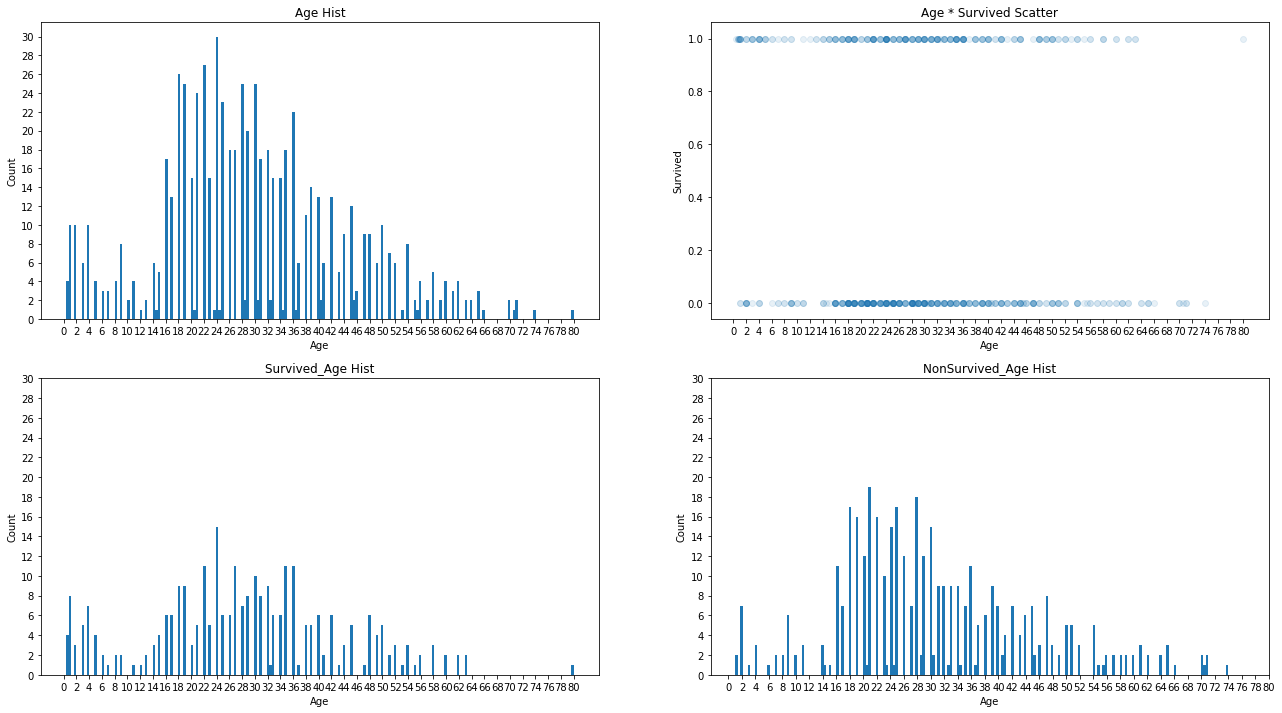

In [45]:
fig = plt.figure(figsize=(22,12))

ax1 = plt.subplot(221)
ax1.hist(df_new['Age'], bins=200)
ax1.set_xticks(np.linspace(0,80,41)) 
ax1.set_yticks(np.linspace(0,30,16)) 
plt.title('Age Hist')
plt.xlabel('Age')
plt.ylabel('Count')

ax2 = plt.subplot(222)
ax2.scatter(df_new['Age'], df_new['Survived'], alpha = 0.1)
ax2.set_xticks(np.linspace(0,80,41)) 
plt.title('Age * Survived Scatter')
plt.xlabel('Age')
plt.ylabel('Survived')

ax3 = plt.subplot(223)
ax3.hist(age_sur['Age'], bins=200)
ax3.set_xticks(np.linspace(0,80,41)) 
ax3.set_yticks(np.linspace(0,30,16)) 
plt.title('Survived_Age Hist')
plt.xlabel('Age')
plt.ylabel('Count')

ax4 = plt.subplot(224)
ax4.hist(age_notsur['Age'], bins=200)
ax4.set_xticks(np.linspace(0,80,41)) 
ax4.set_yticks(np.linspace(0,30,16)) 
plt.title('NonSurvived_Age Hist')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()

##### 以上非空年龄得出的图中，可以看出：

- 年龄总体是右偏分布
- 24岁左右的人最多；16岁以下儿童少，55岁以上老人也少；
- 右图中，16岁以下的倾向于生还；16到48岁之间的总体倾向于遇难，特别是16到31岁之间，生还比率看起来是最低的；48到64岁生还和遇难者人数看起来差不太多；高于64岁的略倾向于遇难，不过年纪最大的那个80岁老人奇迹般生还了
- 一种主观猜测：可能16到48岁的人，更多为了营救其他年龄段的人而牺牲

In [46]:
# 检验年龄是否属于正态分布
w, p = st.shapiro(df_new['Age'])
w, p 

(0.9814548492431641, 7.322165629375377e-08)

- p值很小，可以说年龄不是正态分布，所以也没有办法严格检验生还者年龄和遇难者年龄均值的差异性
- 后续考虑将年龄按照上述分布特征分成几个年龄段

In [47]:
# 查看这位幸存的老人
# 之后可能考虑将这位老人作为年龄的异常值去除
df[df['Age'] > 79]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0,A23,S


In [48]:
print pd.pivot_table(df_new,columns=['Survived'], values = ['Age'], aggfunc=[np.median])
print pd.pivot_table(df_new,columns=['Survived'], values = ['Age'], aggfunc=[np.mean])

         median      
Survived      0     1
Age        28.0  28.0
               mean          
Survived          0         1
Age       30.626179  28.34369


- 遇难者和生还者，中位数一致，都是28，所以可以直接用这个中值填补缺失值
- 均值差异看起来也不算太大，所以可以暂且保留上面那位年龄最高的老人的数据

#### 查看票价和生还状态的关系



/Users/ly11/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/Users/ly11/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


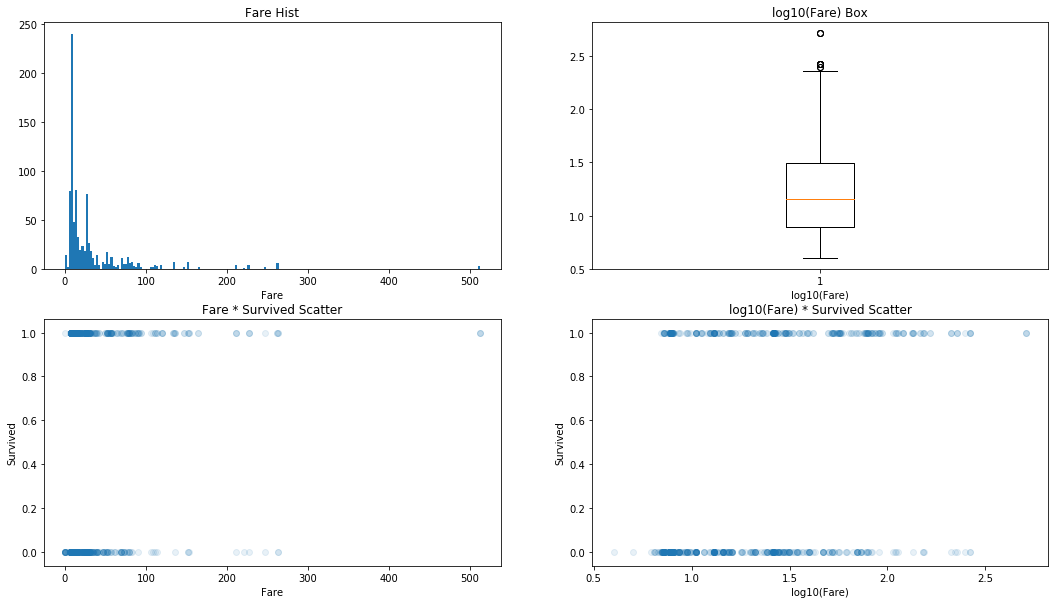

In [49]:
# 探索旅客票价Fare与生还状态的关系
fig = plt.figure(figsize=(18,10))

ax1 = plt.subplot(221)
ax1.hist(df['Fare'],bins=200)
plt.title('Fare Hist')
plt.xlabel('Fare')

ax2 = plt.subplot(222)
ax2.boxplot(np.log10(df['Fare']))
plt.title('log10(Fare) Box')
plt.xlabel('log10(Fare)')

ax3 = plt.subplot(223)
ax3.scatter(df['Fare'], df['Survived'], alpha = 0.1)
#ax3.set_xticks(np.linspace(0,80,17)) 
plt.title('Fare * Survived Scatter')
plt.xlabel('Fare')
plt.ylabel('Survived')

ax4 = plt.subplot(224)
ax4.scatter(np.log10(df['Fare']), df['Survived'], alpha = 0.1)
#ax3.set_xticks(np.linspace(0,80,17)) 
plt.title('log10(Fare) * Survived Scatter')
plt.xlabel('log10(Fare)')
plt.ylabel('Survived')
plt.show()

In [50]:
10**1.65

44.6683592150963

- Fare总体和生还状态关系貌似不大; 不过Fare高于45的似乎略倾向于生还,低于45的略倾向于遇难
- 后续考虑可以将Fare按照百分位数等分为几组

In [51]:
df[df['Fare'] > 500]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


#### 查看兄弟姐妹数量和生还状态的关系

In [52]:
cont_SibSp = pd.pivot_table(df,index=['SibSp'],columns=['Survived'], values = ['PassengerId'],\
               aggfunc=[np.count_nonzero]).fillna(0)
cont_SibSp

count_nonzero       
           PassengerId       
Survived             0      1
SibSp                        
0                398.0  210.0
1                 97.0  112.0
2                 15.0   13.0
3                 12.0    4.0
4                 15.0    3.0
5                  5.0    0.0
8                  7.0    0.0

In [53]:
core_SibSp = cont_SibSp.values
chi_2, p, d_f, hypo = st.chi2_contingency(core_SibSp)
chi_2, p, hypo

(37.271792915204301,
 1.5585810465902147e-06,
 array([[ 374.62626263,  233.37373737],
        [ 128.77777778,   80.22222222],
        [  17.25252525,   10.74747475],
        [   9.85858586,    6.14141414],
        [  11.09090909,    6.90909091],
        [   3.08080808,    1.91919192],
        [   4.31313131,    2.68686869]]))

- 总体上看兄弟姊妹多的，生还率反而不高
- 但比较突出的是，有1个兄弟姐妹的，生还率更高；有0个或更多兄弟姐妹的，生还率都是更低；
- 添加一个SibSp_is1的新特征，如果等于1，为1=Yes；否则为0=No

In [54]:
cont_SibSp['count_nonzero']['PassengerId'][0]

df['SibSp_is1'] = map(lambda x: 1 if x==1 else 0, df['SibSp'])
df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SibSp_is1
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0


In [55]:
cont_SibSp_is1= pd.pivot_table(df,index=['SibSp_is1'],columns=['Survived'], values = ['PassengerId'],\
               aggfunc=[np.count_nonzero])
cont_SibSp_is1

count_nonzero     
            PassengerId     
Survived              0    1
SibSp_is1                   
0                   452  230
1                    97  112

In [56]:
core_SibSp_is1 = cont_SibSp_is1.values
chi_2, p, d_f, hypo = st.chi2_contingency(core_SibSp_is1)
chi_2, p, hypo

(25.856859782670782,
 3.6769563345877817e-07,
 array([[ 420.22222222,  261.77777778],
        [ 128.77777778,   80.22222222]]))

有1个兄弟姐妹的，生还率显著更高；有0个或高于1个的，生还率显著更低

#### 查看父母或孩子数量与生还情况的关系

In [57]:
pd.pivot_table(df,index=['Parch'],columns=['Survived'], values = ['PassengerId'],\
               aggfunc=[np.count_nonzero]).fillna(0)

count_nonzero       
           PassengerId       
Survived             0      1
Parch                        
0                445.0  233.0
1                 53.0   65.0
2                 40.0   40.0
3                  2.0    3.0
4                  4.0    0.0
5                  4.0    1.0
6                  1.0    0.0

- 没有父母或孩子的，生还率低；其他生还和遇难的人数相差不大

#### Embarked与是否生还的关系

In [58]:

cont_Embarked = pd.pivot_table(df,index=['Embarked'],columns=['Survived'], values = ['PassengerId'],\
               aggfunc=[np.count_nonzero])
cont_Embarked

count_nonzero     
           PassengerId     
Survived             0    1
Embarked                   
C                   75   93
Q                   47   30
S                  427  217

In [59]:
core_Embarked = cont_Embarked.values
chi_2, p, d_f, hypo = st.chi2_contingency(core_Embarked)
chi_2, p, hypo

(26.489149839237619,
 1.769922284120912e-06,
 array([[ 103.7480315,   64.2519685],
        [  47.5511811,   29.4488189],
        [ 397.7007874,  246.2992126]]))

Embarked为C的，生还率高于预期；为Q的，生还率不变；为S的，生还率低于预期

### 批量处理训练和测试数据，便于多变量探索和后续输入算法

In [115]:
def ages(df):
    df.Age = df.Age.fillna(df.Age.median())
    bins = (0, 5, 12, 16, 31, 48, 64, 81)
    group_names = ['Baby', 'Child', 'Teenager', 'pre_Adult', 'Adult', 'Middle_aged', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def fares(df):
    df.Fare =df.Fare.fillna(df.Fare.median())
    bins = (-0.9, 8, 15, 31, 600)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df['Fare'], bins, labels=group_names)
    df['Fare'] = categories
    return df


def name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    

def Embarked(df):
    df = df[df['Embarked'].notnull()]
    #df['Female'] = map(lambda x: 1 if x=='female' else 0, df['Sex'])
    #df['Embarked_C'] = map(lambda x: 1 if x=='C' else 0, df['Embarked'])
    #df['Embarked_Q'] = map(lambda x: 1 if x=='Q' else 0, df['Embarked'])
    #df['Embarked_S'] = map(lambda x: 1 if x=='S' else 0, df['Embarked'])
    return df


#def SibSp_and_Parch(df):   
    #df['SibSp_is1'] = map(lambda x: 1 if x==1 else 0, df['SibSp'])   
    #df['Parch_is1'] = map(lambda x: 0 if x==0 else 1, df['Parch'])
    #return df

def drop_features(df):
    df = df.drop(['Ticket','Name','Cabin', 'Embarked'], axis=1)
    return df


def handle_df(df):
    df = ages(df)
    df = fares(df)
    #df = SibSp_and_Parch(df)
    #df = Embarked(df)   
    df = name(df)
    df = drop_features(df)
    return df



In [165]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
825,826,0,3,"Flynn, Mr. John",male,NaN,0,0,368323,6.9500,NaN,Q
175,176,0,3,"Klasen, Mr. Klas Albin",male,18.0,1,1,350404,7.8542,NaN,S
565,566,0,3,"Davies, Mr. Alfred J",male,24.0,2,0,A/4 48871,24.1500,NaN,S


In [166]:
data_train = handle_df(data_train)
data_test = handle_df(data_test)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null category
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null category
Lname          891 non-null object
NamePrefix     891 non-null object
dtypes: category(2), int64(5), object(3)
memory usage: 58.1+ KB


In [167]:
data_train.sample(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Lname,NamePrefix
59,60,0,3,male,Child,5,2,4_quartile,"Goodwin,",Master.
223,224,0,3,male,pre_Adult,0,0,1_quartile,"Nenkoff,",Mr.
395,396,0,3,male,pre_Adult,0,0,1_quartile,"Johansson,",Mr.


#### 现在已将连续数据分段，可以查看多因素的交互影响
由于性别为主要影响因素，这里主要查看在性别相同时，其他变量与生还状态的关系

Text(0,0.5,u'mean(Survived)')

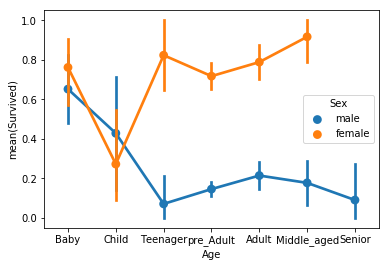

In [208]:
sns.pointplot(x="Age", y="Survived", hue="Sex", data=data_train)
plt.ylabel('mean(Survived)')

可以看到：
- 在年龄较小阶段（婴儿和儿童时期），生还率和性别的关系不太明显，不管是男还是女，婴儿的生还率高于儿童；
- 在青年及以后的年龄阶段，女性的生还率明显高于男性；
- 在青年及以后的年龄阶段，女性随着年龄的增长，生还率先下降后上升；男性随着年龄的增长生还率先上升后下降。

Text(0,0.5,u'mean(Survived)')

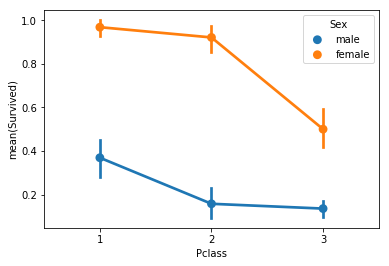

In [209]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train)
plt.ylabel('mean(Survived)')

可以看到：
- 无论男性还是女性，社会阶级地位越高，生还率越高
- 女性生还率整体都比男性高，甚至下层阶级的女性还略高于上层阶级的男性
- 女性上层阶级和中层阶级生还率差异不大，下层阶级女性有一个比较明显的下降； 而男性是在中层就明显下降，中层和下层阶级差异不大

Text(0.5,1,u'Sex = male')

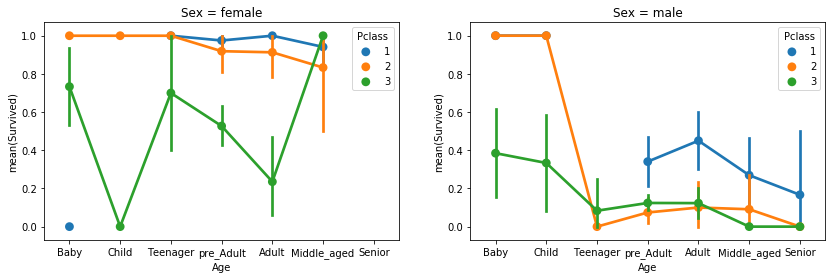

In [219]:
fig = plt.figure(figsize=(14,4))

ax1 = plt.subplot(121)
sns.pointplot(x="Age", y="Survived", hue="Pclass", data=data_train[data_train['Sex']=='female'])
plt.ylabel('mean(Survived)')
plt.title('Sex = female')

ax2 = plt.subplot(122)
sns.pointplot(x="Age", y="Survived", hue="Pclass", data=data_train[data_train['Sex']=='male'])
plt.ylabel('mean(Survived)')
plt.title('Sex = male')

拨开性别和年龄，来看社会阶级与生还状态的关系，可以看到：
- 女性中，上层阶级和中层阶级的女性，几乎全部获救；下层阶级的女性生还率稍低
- 女性中，上层阶级的婴儿、下层阶级的孩子、下层阶级的中年人，都比较异常，推测这里人数比较少，稍后查看详细值
- 男性中，上层阶级都至少是高于或等于16岁的（Teenager定义是16岁以下）
- 男性中，在16岁以上，上层阶级男性生还率高于其他两个阶级的男性；16岁以下，中层阶级的孩子和婴儿，生还率高于下层阶级

In [222]:
# 女性，上层阶级baby和下层阶级child查看
data_train.loc[(data_train['Sex']=='female') & (data_train['Pclass'] == 1) & (data_train['Age'] == 'Baby')]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Lname,NamePrefix
297,298,0,1,female,Baby,1,2,4_quartile,"Allison,",Miss.


验证了我们的猜测，上层阶级唯一一个女婴，不幸遇难

In [223]:
data_train.loc[(data_train['Sex']=='female') & (data_train['Pclass'] == 3) & (data_train['Age'] == 'Child')]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Lname,NamePrefix
24,25,0,3,female,Child,3,1,3_quartile,"Palsson,",Miss.
147,148,0,3,female,Child,2,2,4_quartile,"Ford,",Miss.
419,420,0,3,female,Child,0,2,3_quartile,Van,"Impe,"
541,542,0,3,female,Child,4,2,4_quartile,"Andersson,",Miss.
542,543,0,3,female,Child,4,2,4_quartile,"Andersson,",Miss.
634,635,0,3,female,Child,3,2,3_quartile,"Skoog,",Miss.
813,814,0,3,female,Child,4,2,4_quartile,"Andersson,",Miss.
852,853,0,3,female,Child,1,1,3_quartile,"Boulos,",Miss.


- 下层阶级的8个女孩都没能生还
- 仔细一看，有3个女孩似乎来自同一个家庭，这三个孩子的Lname，SibSp，Parch，Fare，Pclass都是完全一样的；如果他们有4个兄弟姐妹在船上，那么可以推测这个家庭可能只有一个孩子活下来
- 所以下层阶级女孩生还率为0，也可以算少数异常情况

In [229]:
data_train.loc[(data_train['Sex']=='female') & (data_train['Pclass'] == 3) & (data_train['Age'] == 'Middle_aged')]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Lname,NamePrefix
483,484,1,3,female,Middle_aged,0,0,2_quartile,"Turkula,",Mrs.


和我们猜测一样，下层阶级的中年女性只有一个，她生还了所以图上面显示是1

Text(0,0.5,u'mean(Survived)')

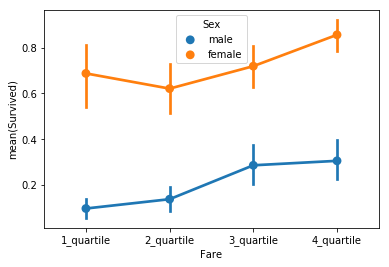

In [211]:
sns.pointplot(x="Fare", y="Survived", hue="Sex", data=data_train)
plt.ylabel('mean(Survived)')

- 对于男性，票价增加，生还率上升
- 对于女性，票价增加，生还率先降低后上升

Text(0.5,1,u'Pclass = 3')

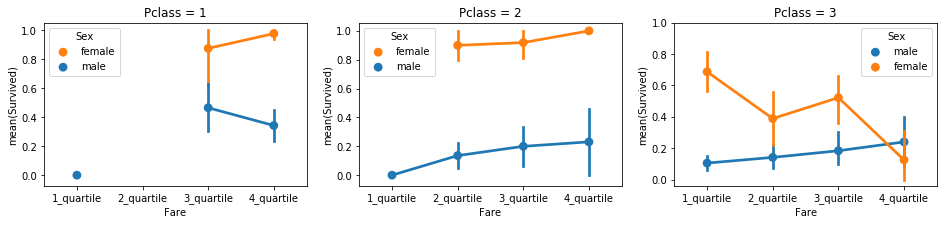

In [218]:
fig = plt.figure(figsize=(16,3))

ax1 = plt.subplot(131)
sns.pointplot(x="Fare", y="Survived", hue="Sex",data=data_train[data_train['Pclass']==1],palette=["C1", "C0"])
ax.set_yticks(np.linspace(0,1.0,6)) 
plt.ylabel('mean(Survived)')
plt.title('Pclass = 1')

ax2 = plt.subplot(132)
sns.pointplot(x="Fare", y="Survived", hue="Sex", data=data_train[data_train['Pclass']==2],palette=["C1", "C0"])
ax2.set_yticks(np.linspace(0,1.0,6)) 
plt.ylabel('mean(Survived)')
plt.title('Pclass = 2')

ax3 = plt.subplot(133)
sns.pointplot(x="Fare", y="Survived", hue="Sex", data=data_train[data_train['Pclass']==3],palette=["C0","C1"])
ax3.set_yticks(np.linspace(0,1.0,6)) 
plt.ylabel('mean(Survived)')
plt.title('Pclass = 3')


- 上层阶级，票价普遍高，只有少数票价低的，稍后可以查看有多少人
- 中层阶级票价相对平衡
- 下层阶级票价低的多，票价高的少
- 有趣的是，整体上不同性别的票价和生还率的关系，跟分阶级后，不同性别的票价和生还率的关系是很不一样的：
    - 中层阶级，不同性别的票价和生还率的关系和整体的趋势还比较一致，男女生还率都随票价增长
    - 在上层阶级中，随着票价增加，男性生还率下降，女性生还率增加
    - 在下层阶级中，随着票价增加，男性生还率是上升的，女性生还率总体却在下降。女性的生还率，从阶级和票价中反映出了较大的差异性

In [239]:
# 上层阶级男性，票价最低档次的人
data_train.loc[(data_train['Sex']=='male') & (data_train['Pclass'] == 1) & (data_train['Fare'] == '1_quartile')]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Lname,NamePrefix
263,264,0,1,male,Adult,0,0,1_quartile,"Harrison,",Mr.
633,634,0,1,male,pre_Adult,0,0,1_quartile,"Parr,",Mr.
806,807,0,1,male,Adult,0,0,1_quartile,"Andrews,",Mr.
815,816,0,1,male,pre_Adult,0,0,1_quartile,"Fry,",Mr.
822,823,0,1,male,Adult,0,0,1_quartile,"Reuchlin,",Jonkheer.
872,873,0,1,male,Adult,0,0,1_quartile,"Carlsson,",Mr.


In [232]:
# 中层阶级男性，票价最低档次的人
data_train.loc[(data_train['Sex']=='male') & (data_train['Pclass'] == 2) & (data_train['Fare'] == '1_quartile')]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Lname,NamePrefix
277,278,0,2,male,pre_Adult,0,0,1_quartile,"Parkes,",Mr.
413,414,0,2,male,pre_Adult,0,0,1_quartile,"Cunningham,",Mr.
466,467,0,2,male,pre_Adult,0,0,1_quartile,"Campbell,",Mr.
481,482,0,2,male,pre_Adult,0,0,1_quartile,"Frost,",Mr.
674,675,0,2,male,pre_Adult,0,0,1_quartile,"Watson,",Mr.
732,733,0,2,male,pre_Adult,0,0,1_quartile,"Knight,",Mr.


- 可以看到两者人数都比较少，而且两者有一些共同特征（后续可以继续探索这些特征，获得更多发现）
    - 都没有兄弟姐妹和父母在船上
    - 都是成年或者准成年人

In [241]:
# 下层阶级女性，票价最高档次的人
data_train.loc[(data_train['Sex']=='female') & (data_train['Pclass'] == 3) & (data_train['Fare'] == '4_quartile')]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Lname,NamePrefix
25,26,1,3,female,Adult,1,5,4_quartile,"Asplund,",Mrs.
71,72,0,3,female,Teenager,5,2,4_quartile,"Goodwin,",Miss.
119,120,0,3,female,Baby,4,2,4_quartile,"Andersson,",Miss.
147,148,0,3,female,Child,2,2,4_quartile,"Ford,",Miss.
180,181,0,3,female,pre_Adult,8,2,4_quartile,"Sage,",Miss.
233,234,1,3,female,Baby,4,2,4_quartile,"Asplund,",Miss.
436,437,0,3,female,pre_Adult,2,2,4_quartile,"Ford,",Miss.
541,542,0,3,female,Child,4,2,4_quartile,"Andersson,",Miss.
542,543,0,3,female,Child,4,2,4_quartile,"Andersson,",Miss.
610,611,0,3,female,Adult,1,5,4_quartile,"Andersson,",Mrs.


我们看到在这个样本中，下层阶级、票价最高档次的女性人数不算很少；但生还率比同样是下层阶级、票价最高档次的男性还要略低

综合以上所有，总体而言：   
* 有些特征之间信息可能有部分重叠，比如NamePrefix和Sex，比如阶级和票价，比如Lname和Parch
* 以上所有图示有可能是随机现象，所有观察结论仅代表现有的数据样本

### 分离数据

In [122]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null category
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null category
Lname          891 non-null object
NamePrefix     891 non-null object
dtypes: category(2), int64(5), object(3)
memory usage: 58.1+ KB


In [123]:
from sklearn import preprocessing

# 生成示性变量
def encode_features(df_train, df_test):
    features = ['Fare', 'Age', 'Sex','Lname','NamePrefix']
    df = pd.concat([df_train[features], df_test[features]])
    
    for f in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[f])
        df_train[f] = le.transform(df_train[f])
        df_test[f] = le.transform(df_test[f])
    
    return df_train, df_test
    

In [124]:
data_train, data_test = encode_features(data_train, data_test)

In [125]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Lname,NamePrefix
0,1,0,3,1,6,1,0,0,100,19
1,2,1,1,0,0,1,0,3,182,20
2,3,1,3,0,6,0,0,0,329,16
3,4,1,1,0,0,1,0,3,267,20
4,5,0,3,1,0,0,0,1,15,19


In [126]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=42)



### 参数调整，模型拟合

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

In [151]:
# 选择分类器
clf1 = RandomForestClassifier(random_state=42)


# 设置参数字典

clf1 = Pipeline([
    ('select_features', SelectKBest(k=5)),
    ('clf', RandomForestClassifier(random_state=42)),
])

parameters1 = dict(clf__n_estimators = [4, 6, 10], 
                   clf__max_features = ['log2', 'sqrt','auto'], 
                   clf__criterion =  ['entropy', 'gini'],
                   clf__max_depth =  [2, 3, 5, 10,15], 
                   clf__min_samples_split = [2, 3, 5, 10],
                   clf__min_samples_leaf = [1,5,8])



# 选择评价标准
acc_scorer = make_scorer(accuracy_score)

# 遍历参数组合
grid_obj = GridSearchCV(clf1, parameters1, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# 选择分数最高的分类器
clf1 = grid_obj.best_estimator_

# 拟合模型
clf1.fit(X_train, y_train)



Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=5, score_func=<function f_classif at 0x1a1dfb1938>)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [152]:
predictions = clf1.predict(X_test)
print(accuracy_score(y_test, predictions))

0.804469273743


In [ ]:
'''
clf2 = AdaBoostClassifier(n_estimators=10,random_state=42)

parameters2 = {'base_estimator': [DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()], 
                  'n_estimators': [20,50,80,110,140],
                  'learning_rate': [0.3,0.5,0.8,1.,1.5]}


acc_scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf2, parameters2, scoring=acc_scorer)

#grid_obj.get_params().keys()
grid_obj = grid_obj.fit(X_train, y_train)
clf2 = grid_obj.best_estimator_

clf2.fit(X_train, y_train)
'''

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

clf2 = Pipeline([
    ('select_features', SelectKBest(k=5)),
    ('clf', DecisionTreeClassifier(random_state=42)),
])

#clf2 = DecisionTreeClassifier(random_state=42)

parameters2 = dict(clf__criterion = ['gini', 'entropy'], 
                  clf__min_samples_split = [2,4,6,8,10],
                  clf__max_depth = [None,5,10,15,20,40],
                  clf__max_features = [None, 'sqrt', 'log2', 'auto'],
                  clf__splitter = ['best','random'])

'''{'criterion': ['gini', 'entropy'], 
                'min_samples_split': [2,4,6,8,10],
                'max_depth': [None,5,10,15,20],
                'max_features':[None, 'sqrt', 'log2', 'auto'],
                'splitter':['best','random']}'''

acc_scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf2, parameters2, scoring=acc_scorer)

#grid_obj.get_params().keys()
grid_obj = grid_obj.fit(X_train, y_train)
clf2 = grid_obj.best_estimator_

clf2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=5, score_func=<function f_classif at 0x1a1dfb1938>)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])

In [162]:
predictions2 = clf2.predict(X_test)
print(accuracy_score(y_test, predictions2))

0.837988826816


In [138]:
clf3 = SVC(kernel="rbf")

parameters3 = {'C': [1, 10, 100, 1000,10000], 
                  'max_iter': [-1, 10, 50,100],
                  'shrinking': [True, False],
                   'random_state':[42],
                  'decision_function_shape': ['ovo', 'ovr', 'ovr']}

acc_scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf3, parameters3, scoring=acc_scorer)

#grid_obj.get_params().keys()
grid_obj = grid_obj.fit(X_train, y_train)
clf3 = grid_obj.best_estimator_

clf3.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [139]:
predictions3 = clf3.predict(X_test)
print(accuracy_score(y_test, predictions3))

0.597765363128


### 交叉验证

In [140]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10, random_state=42)
    print kf
    outcomes = []
    fold = 0

    for train_index, test_index in kf:            
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print "Fold {0} accuracy: {1}".format(fold, accuracy) 


    mean_outcome = np.mean(outcomes)
    print '\n'
    print "Mean Accuracy: {0}".format(mean_outcome)



In [157]:
run_kfold(clf1)

sklearn.cross_validation.KFold(n=891, n_folds=10, shuffle=False, random_state=42)
Fold 1 accuracy: 0.8
Fold 2 accuracy: 0.865168539326
Fold 3 accuracy: 0.797752808989
Fold 4 accuracy: 0.85393258427
Fold 5 accuracy: 0.85393258427
Fold 6 accuracy: 0.808988764045
Fold 7 accuracy: 0.775280898876
Fold 8 accuracy: 0.786516853933
Fold 9 accuracy: 0.876404494382
Fold 10 accuracy: 0.797752808989


Mean Accuracy: 0.821573033708


In [163]:
run_kfold(clf2)

sklearn.cross_validation.KFold(n=891, n_folds=10, shuffle=False, random_state=42)
Fold 1 accuracy: 0.722222222222
Fold 2 accuracy: 0.842696629213
Fold 3 accuracy: 0.808988764045
Fold 4 accuracy: 0.831460674157
Fold 5 accuracy: 0.842696629213
Fold 6 accuracy: 0.831460674157
Fold 7 accuracy: 0.786516853933
Fold 8 accuracy: 0.797752808989
Fold 9 accuracy: 0.865168539326
Fold 10 accuracy: 0.842696629213


Mean Accuracy: 0.817166042447


In [144]:
run_kfold(clf3)

sklearn.cross_validation.KFold(n=891, n_folds=10, shuffle=False, random_state=42)
Fold 1 accuracy: 0.633333333333
Fold 2 accuracy: 0.707865168539
Fold 3 accuracy: 0.640449438202
Fold 4 accuracy: 0.539325842697
Fold 5 accuracy: 0.595505617978
Fold 6 accuracy: 0.61797752809
Fold 7 accuracy: 0.550561797753
Fold 8 accuracy: 0.61797752809
Fold 9 accuracy: 0.674157303371
Fold 10 accuracy: 0.61797752809


Mean Accuracy: 0.619513108614


- 从上面的结果来看，随机森林鲁棒性相对更高；决策树第一折分数较低，整体也不错
- 支持向量机由于是全量特征建模，所以效果不好

## 预测数据

In [153]:
ids = data_test['PassengerId']
predictions = clf1.predict(data_test.drop('PassengerId', axis=1))

predictions2 = clf2.predict(data_test.drop('PassengerId', axis=1))
predictions3 = clf2.predict(data_test.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [155]:
output.to_csv('titanic-predictions1.csv', index=False)

### 通过以上步骤，在Kaggle的最终测试集上：
- 随机森林输出结果的得分最高，为0.79425，决策树输出结果的得分为0.77990
- 但由于随机森林是集成学习算法，运行速度上比决策树慢了许多
- 以上结果算不上好，截止3月29号排在前22%，后续还需要继续调整

### 针对训练数据集的描述性结论：
- **性别上**：
    - 整体而言，女性比男性生还率显著更高

- **年龄上**：
    - 在年龄较小阶段（婴儿和儿童时期），生还率和性别的关系不太明显，不管是男还是女，婴儿的生还率高于儿童；
    - 在青年（12岁）及以后的年龄阶段，女性的生还率明显高于男性；
    - 在青年及以后的年龄阶段，女性随着年龄的增长，生还率先下降后上升；男性随着年龄的增长生还率先上升后下降。

- **社会阶层上**：
    - 无论男性还是女性，社会阶级地位越高，生还率越高
    - 女性生还率整体都比男性高，甚至下层阶级的女性都要略高于上层阶级的男性
    - 女性上层阶级和中层阶级生还率差异不大，下层阶级女性有一个比较明显的下降；而男性是在中层阶级生还率就明显下降，中层和下层阶级差异不大
    
- **票价上**：
    - 上层阶级，票价都在中等档次及以上；随着票价增加，男性生还率下降，女性生还率增加
    - 中层阶级票价相对平衡，不同性别的票价和生还率的关系和整体趋势比较一致，即男女生还率都随票价增长
    - 上层和中层阶级中，票价最低档次的男性，生还率为0，这些人都没有家庭成员在船上，都在16岁到48岁之间
    - 下层阶级票价低的多，票价高的少；随着票价增加，男性生还率是上升的，女性生还率总体却在下降
    
- **不同性别的生还率，从阶级和票价中反映出了较大的差异性**：
    - 尽管女性总体的生还率高，但下层阶级女性的票价越高，她们的生还率反而越低，这与上层阶级的女性是相反的
    - 下层阶级的女性购买最低档次的票价，还可以得到照顾，生还率能到0.7；下层阶级女性购买最高档次的票价，却不会受到更多优待，生还率只有0.1；这与同样购买最高档次票价的上层和中层阶级女性（0.9左右），形成鲜明对比
    - 尽管男性总体的生还率低，但下层阶级男性的票价越高，他们的生还率是在上升的，这与上层阶级的男性是相反的



#### 注：以上细分出来的差异，目前只是该样本的观察结果，很可能因为细分出的生还率所对应分组的分母大小不一样，导致没有统计上的显著性。
* 尽管如此，我们仍然能够初步实现我们的目的，即：找出大致什么特征的人会生还——
    - 上层和中层阶级的12岁以上的女性，以及中层阶级12岁以下的婴儿和孩子，生还率最高，几乎所有都生还了
    - 其次的是下层阶级的12岁以下婴儿和孩子（上层阶级一共只有1个女婴，未生还）
    - 再其次是下层阶级的12岁以上的女性，这部分女性中，票价高的生还率反而更低；
    - 然后是上层阶级的男性（全为16岁以上）
    - 最后是中层和下层阶级中12岁以上的男性，这部分男性生还率最低；但在这部分群体中，票价高的生还率要高于票价低的
    


可以主观推测的一些原因（无法绝对验证）：
* 成年男性，尤其是中下层的，或者没有家庭成员在船上的成年男性，可能承担了较多的营救妇女和少儿的责任
* 下层女性购买高票价，可能受到了同样购买高票价的中上层阶级的不认同和不公平待遇
* 付出高票价的下层阶级成年男性，可能倾向于注重享乐，缺少责任感